#### Title: Classifying Red Wine Quality - Group 21

#### Introduction

"Vinho Verde'' is a Portuguese wine which has three main variants, of which we will be considering red. In the kaggle dataset we are using from UCI Machine Learning, its quality is affected by 11 different physicochemical variables, such as acidity, chlorides, density, etc.. These 11 variables determine the quality of the wine, on a scale from 0-10. We will conduct our data analysis using three predictors from our dataset: _fixed acidity, alcohol content, and pH_. We decided on these three predictors due to the online accessibility of this information; many red wine companies do not share the finer contents of their wines, such as sulfur dioxide, density, volatile and citric acids, etc. However alcohol content, fixed acidity, and pH are far more easily found and therefore the best predictors to answer our question.

Since this proposal is a classification task, we will build a classifier to categorize wines as either good or poor in quality - for which we will be using the K-nearest neighbors classification algorithm. The classifier will be trained to recognize the quality of wine based on the three predictors outlined above. We will define good quality wine as having a quality rating over _6.5_ and anything below as poor quality. The good quality wines will be assigned _1_ and the poor quality wines will be assigned _0_. This is done for the purpose of making a binary classifier, rather than a multiclass one, creating more concrete distinctions between the qualities of the wines and avoiding an unecessarily complex model that may have lower accuracy.

Our ultimate goal is to use this classifier to classify the quality of various red wines at different price points that are sourced from outside of the dataset. This will ultimately help us determine whether or not the differences in the qualities of the wines correspond to their differences in price. We can rephrase this as a predictive research question: Given a k-means classifier, does a difference in the quality of a red wine reflect a difference in its price?

#### Preliminary exploratory data analysis

In [2]:
library(dplyr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)
install.packages("themis")
library(themis)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

After loading in the necessary libraries, we first read in the red wine data, using the "mutate" and "ifelse" functions in conjunction to create a new column, distinguishing the wines as either good or poor. The original dataset sets the threshold for a good wine at >6.5 and we followed this in our code. We called this new column "new_quality" to make it distinct from the existing "quality" column and finally, removed white spaces from between the column names to be able to call on them, later. 

In [3]:
red_wine <- read_csv("data/winequality-red.csv")|>
    mutate(new_quality = ifelse(quality < 6.5, 0, 1)) |>
    mutate(new_quality = as_factor(new_quality))

colnames(red_wine) <- make.names(colnames(red_wine))
red_wine

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,new_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6,0
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5,0
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6,0


Before we build our classifier, we can visualize and create tables for the original data to extract more information from it. We chose to create a simple ggpairs matrix to simultaneously observe the relationships between our chosen predictors and the binary wine quality. Since we are interested in how the quality varies with each predictor, we focussed on the rightmost four graphs in the matrix (3 boxplots and 1 bargraph). 

Observing the graph of new quality v. fixed acidity, we noticed that wines falling in the "good" class or the *1* class had a higher average fixed acidity. With this reasoning, good quality wines had a higher average alcohol content and lower average pH. However, the differences between these averages are not significant, suggesting that the classifier may have difficulty distinguishing between qualities given the small range of alcohol, fixed acidity, and pH values. 

The proportion of good wines to poor wines was also noted in the bottom right bar graph, exposing how good wine is a minority class. This indicates that the data will have to be balanced or upscaled at some point in the analysis to avoid the classifier being biased towards the majority class - poor quality wine - when making predictions on the testing data. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



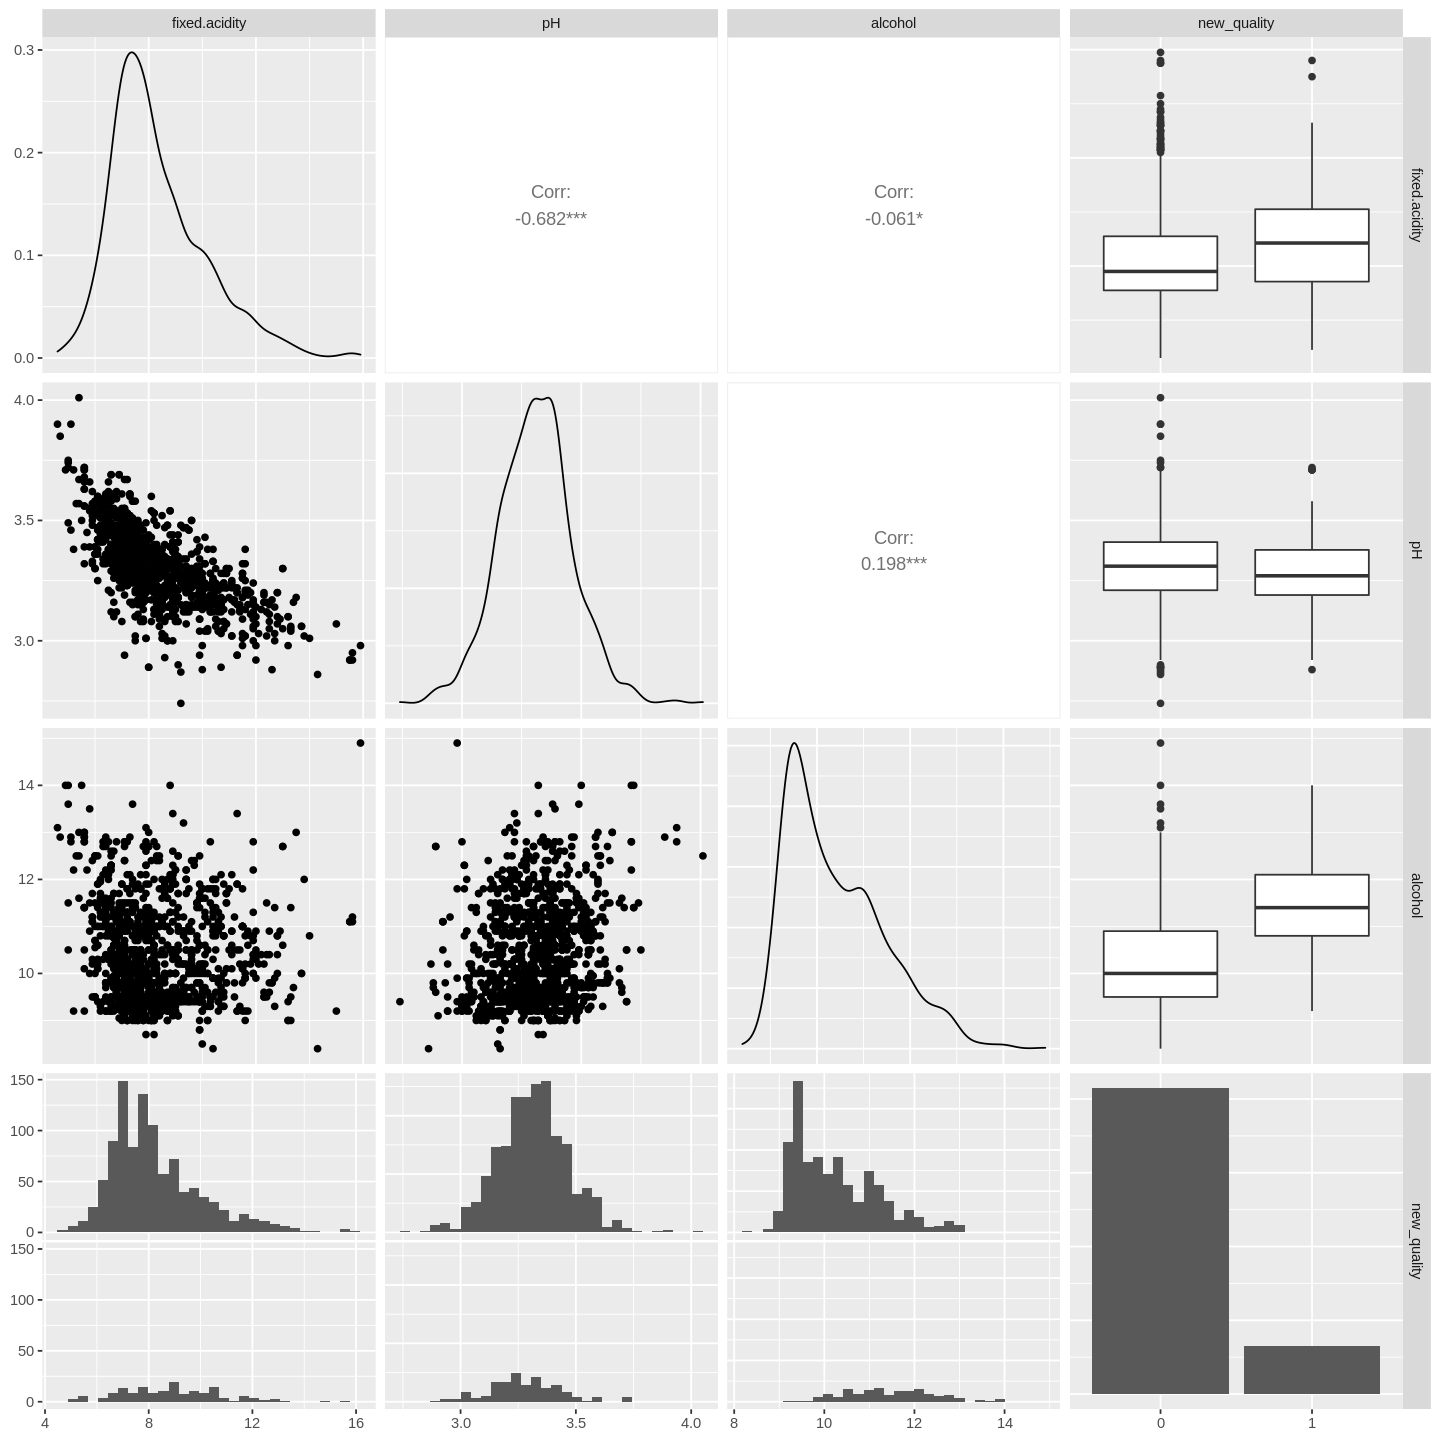

In [15]:
options(repr.plot.height = 12, repr.plot.width = 12)
library(ggplot2)
library(GGally)

my_ggpairs <- ggpairs(red_wine_train, columns = c("fixed.acidity", "pH", "alcohol", "new_quality"))
my_ggpairs

Following the visualization, we created three more informative tibbles. The first of these shows the mean values of each predictor which, though not explicitly relevant, does show that the predictors have different scales and that they will need to be normalized in the analysis to create a reliable classifier. The second tibble shows the exact proportion of poor to good wines, with good wines making up only 13.5% of the dataset - further indication that we should balance it in the analysis. Finally, we determine that there are no missing values in the dataset. This preliminary exploration of the data informs our decisions in the analysis portion of the proposal.

In [17]:
red_wine_quality_count <- red_wine_train |>
    group_by(new_quality) |>
    summarize(count = n())

missing_data <- red_wine_train |>
    summarize(empty_rows = sum(is.na(" ")))

red_wine_mean <- red_wine_train |>
    select(-quality) |>
    summarize(across(fixed.acidity:alcohol, mean))

red_wine_mean
red_wine_quality_count
missing_data


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.340818,0.5268781,0.2732972,2.572621,0.08726711,15.94407,46.95534,0.9967854,3.309457,0.6565109,10.40488


new_quality,count
<fct>,<int>
0,1036
1,162


empty_rows
<int>
0


To train the k-means classifier, we split the mutated red wine data into 75% training and 25% testing data. We specified that the class on which to base the splitting was new_quality, as this is the class we will be working with.

In [10]:
set.seed(2020)
red_wine_split <- initial_split(red_wine, prop = 0.75, strata = new_quality)

red_wine_train <- training(red_wine_split)# |>
    #group_by(new_quality) |>
    #slice_sample(n = max(table(red_wine$new_quality)), replace = TRUE)

red_wine_test <- testing(red_wine_split)

Now having the testing and training data, we created a recipe for the training data with the three predictors outline in the introduction - alcohol, pH, and fixed acidity. We scaled and centered all the predictors in the recipe to ensure that every predictor has an equal influence over the model. We also chose to upsample the underepresented "good" quality wines as they only comprised 13.5% of the original data. This is done to prevent the classifier from being biased to the overepresented "poor" quality wines and making inaccurate predictions.

We then created a knn model, specifying the task to be classification, and set the neighbors to tune(), since we needed to optimize the k value we would use in the final model. The number of neighbors considered in the cross validation will be from 1-10, sequentially.  

In [21]:
    wine_recipe <- recipe(new_quality~ alcohol + pH + fixed.acidity, data = red_wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(new_quality, over_ratio = 1, skip = TRUE)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_vfold <- vfold_cv(red_wine_train, v = 10, strata = new_quality)

kvals <- tibble(neighbors = seq(1,10))

With the recipe and model created, we passed them into the workflow and generated results for various mean accuracies corresponding to various numbers of neighbors. To determine the optimal *k*, we created a plot of the mean vs. neighbors, identifying this value of *k* to be 2, as seen below. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8631127,10,0.006575221,Preprocessor1_Model02
1,accuracy,binary,0.8622862,10,0.006205485,Preprocessor1_Model01
3,accuracy,binary,0.8195689,10,0.008984122,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.7553093,10,0.01236528,Preprocessor1_Model08
9,accuracy,binary,0.7353363,10,0.01370639,Preprocessor1_Model09
10,accuracy,binary,0.7353363,10,0.01370639,Preprocessor1_Model10


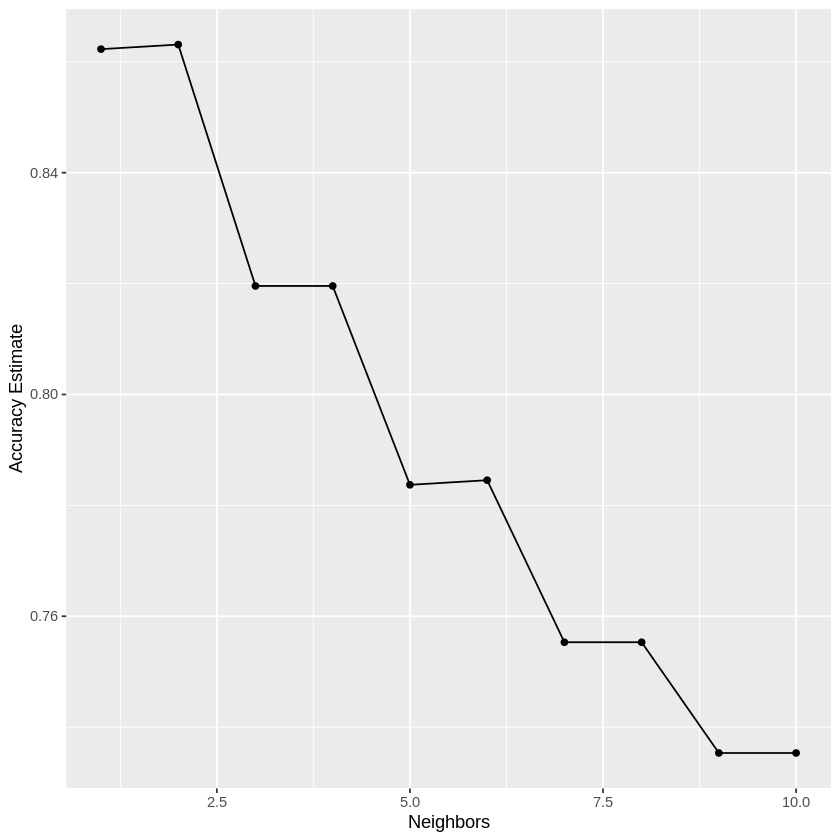

In [22]:
wine_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean))

accuracy_versus_k <- ggplot(wine_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k
wine_results

Having our optimal *k*, we recreated our classification model, fitting the recipe and model to our training data after passing it through the workflow. The testing data was then used to generate accuracy metrics for the classifier, including a confusion matrix. From this, we gathered that our final classifier has a reasonable accuracy of 86% using *k* = 2.

In [23]:
knn_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_2) |>
       fit(data = red_wine_train)

wine_test_predictions <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |>
       metrics(truth = new_quality, estimate = .pred_class) 

wine_mat <- predict(wine_fit, red_wine_test) |>
       bind_cols(red_wine_test) |> 
       conf_mat(truth = new_quality, estimate = .pred_class)

wine_test_predictions
wine_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8603491
kap,binary,0.4595687


          Truth
Prediction   0   1
         0 312  22
         1  34  33

Using our knowledge of classification, we successfully built a reliable k-means model that can classify wines into two categories - good or poor - based on their pH, alcohol, and levels of fixed acidity. With this model, it is now possible to predict the qualities of red wines sourced outside of our dataset. To involve variety in our choices, we selected cheap, medium-priced, and expensive wines from a single website, taking their predictor details and creating new tibbles for each one. We then passed these new observations through the predict function with our fitted model.

In [24]:
cheap_wine <- tibble(pH = 3.58,
                   fixed.acidity = 6.3,
                    alcohol = 13.9)

cheap_wine_2 <- tibble(pH = 3.77,
                   fixed.acidity = 5.3,
                    alcohol = 13.5)

cheap_wine_3 <- tibble(pH = 3.76,
                   fixed.acidity = 5.3,
                    alcohol = 14.5)

medium_wine <- tibble(pH = 3.7,
                   fixed.acidity = 7.07,
                    alcohol = 14.5)

exp_wine <- tibble(pH = 3.62,
                   fixed.acidity = 6.9,
                    alcohol = 13.5)

cheap_wine_predict <- predict(wine_fit, cheap_wine)
cheap_wine_2_predict <- predict(wine_fit, cheap_wine_2)
medium_wine_predict <- predict(wine_fit, medium_wine)
exp_wine_predict <- predict(wine_fit, exp_wine)
cheap_wine_3_predict <- predict(wine_fit, cheap_wine_3)

cheap_wine_predict
medium_wine_predict
exp_wine_predict
cheap_wine_2_predict
cheap_wine_3_predict

.pred_class
<fct>
1


.pred_class
<fct>
1


.pred_class
<fct>
0


.pred_class
<fct>
1


.pred_class
<fct>
1


#### Methods

We will conduct our data analysis using three predictors from our dataset: fixed acidity, alcohol content, and pH. We decided on these three predictors due to the online accessibility of this information; many red wine companies do not share the finer contents of their wines, such as sulfur dioxide, density, volatile and citric acids, etc. However alcohol content, fixed acidity, and pH are far more easily found and therefore the best predictors to answer our question.

To visualize our data, we have created three histograms, showing the distribution of wine quality according to each predictor. We have done this to focus on the effect of the predictors on the quality of wine. We will use this visualization to try and understand which specific amount of variable (alcohol content, pH, and fixed acidity) would correspond to a higher quality rating. These graphs hint at how the classifier we train will end up classifying wines as either higher or lower quality, and where the ranges of the predictors fall for higher quality wines.

- specify classification algorithm used
- More detailed explanation is required in how this visulization leads to better understand the relation between predictor vs target

#### Expected Outcomes & Significance

We expect to find the quality of wine based on the classifier we have created. Taking the Vinho Verde dataset, we will use our classifier to distinguish between the various wines in the sample based on three predictors, ranging from 0 to 10. 

If the classifier successfully identifies the quality of the red wine samples (related to their prices), separate from the data set, our classifier would demonstrate efficiency and accuracy that could be useful for data outside of ours. This can be a pioneering method in the wine industry that can be utilized commercially for pricing wine based on physical quality, or allow wine connoisseurs to assess wines digitally.

One question emerging from our results could be whether K-nearest neighbor classification could change the way the wine industry prices new wines. Should this classifier become a routine part of the industry, would it become a quicker way to distinguish between wine qualities and price them appropriately? Additionally, could current wine prices change?

- provide more detail on the expected outcomes and the potential significance of the findings
- acknowledge the limitations of the study and suggest potential avenues for future research